# Imports

In [1]:
import pandas as pd

from coordinate_matching import *
import time

# Code

# Example 1: Artificial data

# Example 2: Real data

We will match MaNGA with Galaxy Zoo DECaLS on their coordinates.

In [2]:
df_manga = pd.read_csv('data/manga_coordinates.csv')
df_gz = pd.read_csv('data/gzdecals_coordinates.csv')

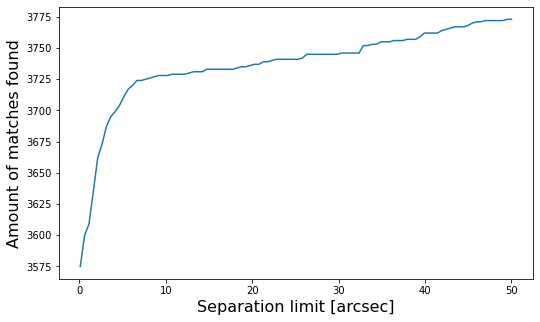

It took 0.39 seconds.


In [5]:
start_time = time.time()

catalog_match_plot_separation_radius([df_manga['objra'],df_manga['objdec']],
                                     [df_gz['ra'],df_gz['dec']])


print(f'It took {np.round(time.time() - start_time,2)} seconds.')

In [18]:
lst = np.array([1,2,3])

In [19]:
lst

array([1, 2, 3])

In [20]:
lst = np.array(lst)

In [21]:
lst

array([1, 2, 3])

In [4]:
df = df_manga.merge(df_gz, left_on = 'iauname',right_on = 'iauname', how='inner')

In [5]:
len(df)

3702

In [7]:
idx, _, _, _ = match_catalogs([np.array(df_manga['objra']),np.array(df_manga['objdec'])],
               [np.array(df_gz['ra']),np.array(df_gz['dec'])],
               limit = 10)

  0%|          | 0/313789 [00:00<?, ?it/s]

  0%|          | 0/310107 [00:00<?, ?it/s]

  0%|          | 0/7591 [00:00<?, ?it/s]

  0%|          | 0/11273 [00:00<?, ?it/s]

In [12]:
len(np.where(~np.isnan(idx))[0])

3684